# Cat vs Dog Classification with Tensorflow 2 and Keras

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1_vJYv58OIW6AVRCbPczLJtwTbt2t4CAk?usp=sharing)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds


## Loading and Setting up Data Pipeline

In [2]:
ds, info = tfds.load("cats_vs_dogs", with_info=True)

In [3]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and Saul, Jared},
    title = {Asirra: A CAPTCHA that Exploits Interest-Aligned Manual Image Categorization},
    booktitle = {Proceedings of 14th ACM Conference on Computer and Communications Security (CCS)},
    ye

In [20]:
num_classes = 1

In [21]:
# Split train, val, and test sets
train_ds = ds["train"]
split_size = 0.3
number_of_imgs = tf.data.experimental.cardinality(train_ds).numpy()
test_ds = train_ds.take(int(split_size*number_of_imgs))
train_ds = train_ds.skip(int(split_size*number_of_imgs))

In [22]:
number_of_imgs = tf.data.experimental.cardinality(train_ds).numpy()
val_ds = train_ds.take(int(split_size*number_of_imgs))
train_ds = train_ds.skip(int(split_size*number_of_imgs))

In [23]:
# Preprocessing functions
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE
def preprocess(img_info):
  img, label = img_info["image"], img_info["label"]
  # img = tf.cast(img, tf.float32) / 255.
  img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  return img, label

In [24]:
# Data Pipeline
train_ds = train_ds.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)
test_ds = test_ds.map(preprocess).batch(BATCH_SIZE).prefetch(AUTOTUNE)

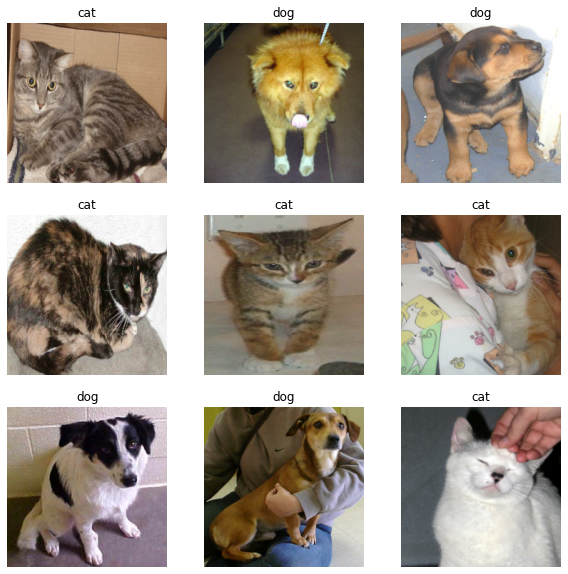

In [25]:
class_names = ["cat", "dog"]
# Visualize some images
def show_imgs(data):
  plt.figure(figsize=(10, 10))
  for images, labels in data.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(f"{class_names[labels[i]]}")
      plt.axis("off")

show_imgs(train_ds)

## 3 layer Conv2D

In [10]:
mkpt = tf.keras.callbacks.ModelCheckpoint(filepath="./models/",
                                          save_best_only=True) # save the best model
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./logs") # log with tensorboard
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3) # early stopping
callbacks=[mkpt, tensorboard, early_stopping]
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(256, 3, activation="relu", padding="same", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(62, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=["accuracy"])


In [11]:
model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
179/179 [==============================] - 70s 327ms/step - loss: 7.4959 - accuracy: 0.5049 - val_loss: 0.6931 - val_accuracy: 0.4884
INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 2/10
179/179 [==============================] - 55s 262ms/step - loss: 0.6927 - accuracy: 0.5071 - val_loss: 0.6911 - val_accuracy: 0.4884
INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 3/10
179/179 [==============================] - 55s 264ms/step - loss: 0.6861 - accuracy: 0.5094 - val_loss: 0.6896 - val_accuracy: 0.4897
INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 4/10
179/179 [==============================] - 55s 263ms/step - loss: 0.6830 - accuracy: 0.5122 - val_loss: 0.6872 - val_accuracy: 0.4888
INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 5/10
179/179 [==============================] - 55s 262ms/step - loss: 0.6769 - accuracy: 0.5167 - val_loss: 0.6882 - val_accuracy: 0.4899
Epoch 6/10
179/179 [==============================] - 55s 264ms/step - loss: 0.6716 - accuracy: 0.5233 - val_loss: 0.6872 - val_accuracy: 0.4907
Epoch 7/10
179/179 [==============================] - 55s 262ms/step - loss: 0.6664 - accuracy: 0.5356 - val_loss: 0.6891 - val_accuracy: 0.4917


In [ ]:
# def show_res(imgs, rows=1, cols=10):
#   fig = plt.figure(figsize=(30, 20))
#   count = 0
#   for row in range(rows):
#     for col in range(cols):
#       fig.add_subplot(rows, cols, count+1)
#       plt.imshow(imgs[count])
#       plt.axis("off")
#       count += 1

#   # fig.suptitle("Correct predictions")
# imgs = batch_imgs.numpy()[batch_labels.numpy() == preds_labels]
# show_res(imgs)


## Transfer Learning

### Resnet Backbone

In [15]:
resnet = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
resnet_preprocess = tf.keras.applications.resnet50.preprocess_input

94773248/94765736 [==============================] - 1s 0us/step


In [16]:
# Download and create pretrained resnet using the subclassing API
class MyModel(tf.keras.models.Model):
  def __init__(self, num_classes):
    super(MyModel, self).__init__()
    self.embed = resnet
    # self.embed.trainable=False
    self.gap = tf.keras.layers.GlobalAveragePooling2D()
    self.dropout = tf.keras.layers.Dropout(0.2)
    # self.dense1 = tf.keras.layers.Dense(128, activation="relu")
    self.dense2 = tf.keras.layers.Dense(num_classes)

  def call(self, inputs):
    x = self.embed(inputs, training=False)
    x = self.gap(x)
    x = self.dropout(x)
    # x = self.dense1(x)
    x = self.dense2(x)
    return x

  

In [17]:
# Image augmentation for overfitting
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"), # horizontal flip
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2) # randomly rotate the images
])

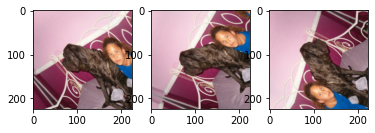

In [36]:
# Visualizing augmented data
for batch_imgs, batch_labels in train_ds.take(1):
  for i in range(3):
    batch_imgs_augmented = data_augmentation(batch_imgs[0][tf.newaxis,:])
    plt.subplot(1, 3, i + 1)
    plt.imshow(tf.reshape(batch_imgs_augmented, (224, 224, 3)).numpy().astype(np.uint8))
    

### Functional API Resnet

In [37]:
# freeze the weights of the pretrained network
resnet.trainable = False
# preprocess_input = tf.keras.applications.resnet50.preprocess_input

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# model = MyModel(num_classes=1)
inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = resnet_preprocess(x)
x = resnet(x, training=False) # freeze batchnorm layers' trainable variables
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [39]:
model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10
179/179 [==============================] - 52s 245ms/step - loss: 0.4928 - accuracy: 0.7398 - val_loss: 0.2122 - val_accuracy: 0.9189


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 2/10
179/179 [==============================] - 41s 185ms/step - loss: 0.2175 - accuracy: 0.9189 - val_loss: 0.1178 - val_accuracy: 0.9654


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 3/10
179/179 [==============================] - 50s 235ms/step - loss: 0.1556 - accuracy: 0.9450 - val_loss: 0.0861 - val_accuracy: 0.9756


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 4/10
179/179 [==============================] - 41s 185ms/step - loss: 0.1270 - accuracy: 0.9551 - val_loss: 0.0710 - val_accuracy: 0.9799


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 5/10
179/179 [==============================] - 50s 236ms/step - loss: 0.1076 - accuracy: 0.9613 - val_loss: 0.0615 - val_accuracy: 0.9816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 6/10
179/179 [==============================] - 41s 185ms/step - loss: 0.1005 - accuracy: 0.9625 - val_loss: 0.0552 - val_accuracy: 0.9844


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 7/10
179/179 [==============================] - 41s 185ms/step - loss: 0.0940 - accuracy: 0.9679 - val_loss: 0.0517 - val_accuracy: 0.9865


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 8/10
179/179 [==============================] - 41s 185ms/step - loss: 0.0872 - accuracy: 0.9669 - val_loss: 0.0479 - val_accuracy: 0.9867


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 9/10
179/179 [==============================] - 41s 186ms/step - loss: 0.0847 - accuracy: 0.9673 - val_loss: 0.0452 - val_accuracy: 0.9867


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


Epoch 10/10
179/179 [==============================] - 41s 186ms/step - loss: 0.0819 - accuracy: 0.9703 - val_loss: 0.0436 - val_accuracy: 0.9875


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ./models/assets


INFO:tensorflow:Assets written to: ./models/assets


### Resnet with Subclassing

In [40]:
# resnet
resnet.trainable = False
model = MyModel(1)
inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = resnet_preprocess(x)
x = model(x)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [41]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( multiple                  0         
_________________________________________________________________
dropout_3 (Dropout)          multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  2049      
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [42]:
model.fit(train_ds, epochs=10, validation_data=val_ds, callbacks=callbacks)

Epoch 1/10
179/179 [==============================] - 43s 181ms/step - loss: 0.4649 - accuracy: 0.7684 - val_loss: 0.2197 - val_accuracy: 0.9290
Epoch 2/10
179/179 [==============================] - 39s 172ms/step - loss: 0.1909 - accuracy: 0.9328 - val_loss: 0.1388 - val_accuracy: 0.9541
Epoch 3/10
179/179 [==============================] - 48s 222ms/step - loss: 0.1341 - accuracy: 0.9535 - val_loss: 0.1094 - val_accuracy: 0.9621
Epoch 4/10
179/179 [==============================] - 39s 172ms/step - loss: 0.1102 - accuracy: 0.9589 - val_loss: 0.0944 - val_accuracy: 0.9662
Epoch 5/10
179/179 [==============================] - 48s 222ms/step - loss: 0.0951 - accuracy: 0.9670 - val_loss: 0.0852 - val_accuracy: 0.9681
Epoch 6/10
179/179 [==============================] - 39s 172ms/step - loss: 0.0840 - accuracy: 0.9713 - val_loss: 0.0793 - val_accuracy: 0.9720
Epoch 7/10
179/179 [==============================] - 48s 223ms/step - loss: 0.0763 - accuracy: 0.9732 - val_loss: 0.0749 - val_ac

### Mobilenet

In [43]:
mobilenet = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), weights="imagenet")
mobilenet_preprocess = tf.keras.applications.mobilenet_v2.preprocess_input

9412608/9406464 [==============================] - 0s 0us/step


In [44]:
# data augmentation to reduce overfitting
# randomly flip and rotate the images
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [45]:
# freeze the weights of the pretrained network
mobilenet.trainable = False
# preprocess_input = tf.keras.applications.resnet50.preprocess_input

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
# model = MyModel(num_classes=1)
inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = mobilenet_preprocess(x)
x = mobilenet(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_mobilenet = tf.keras.Model(inputs, outputs)
# outputs = model(x)

model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [46]:
model_mobilenet.fit(train_ds, epochs=10, callbacks=[callback], validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


179/179 [==============================] - 39s 152ms/step - loss: 0.5982 - accuracy: 0.6837 - val_loss: 0.3037 - val_accuracy: 0.9472
Epoch 2/10
179/179 [==============================] - 34s 146ms/step - loss: 0.2893 - accuracy: 0.9122 - val_loss: 0.1696 - val_accuracy: 0.9738
Epoch 3/10
179/179 [==============================] - 34s 147ms/step - loss: 0.2026 - accuracy: 0.9413 - val_loss: 0.1215 - val_accuracy: 0.9783
Epoch 4/10
179/179 [==============================] - 34s 147ms/step - loss: 0.1689 - accuracy: 0.9460 - val_loss: 0.0979 - val_accuracy: 0.9803
Epoch 5/10
179/179 [==============================] - 34s 146ms/step - loss: 0.1462 - accuracy: 0.9513 - val_loss: 0.0833 - val_accuracy: 0.9826
Epoch 6/10
179/179 [==============================] - 34s 146ms/step - loss: 0.1377 - accuracy: 0.9541 - val_loss: 0.0742 - val_accuracy: 0.9836
Epoch 7/10
179/179 [==============================] - 34s 147ms/step - loss: 0.1250 - accuracy: 0.9551 - val_loss: 0.0675 - val_accuracy: 0.9

### Fine Tuning with mobilenet

In [47]:
mobilenet.trainable = True


In [48]:
print("Number of layers in the base model: ", len(mobilenet.layers))
fine_tune_at = 100
for layer in mobilenet.layers[:fine_tune_at]:
  layer.trainable = False


Number of layers in the base model:  154


In [49]:
inputs = tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = mobilenet_preprocess(x)
x = mobilenet(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_mobilenet = tf.keras.Model(inputs, outputs)
model_mobilenet.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.RMSprop(lr=0.0001/10),
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [52]:
model_mobilenet.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1280)              0   

In [51]:
model_mobilenet.fit(train_ds, epochs=10, callbacks=[callback], validation_data=val_ds)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


179/179 [==============================] - 41s 162ms/step - loss: 0.3431 - accuracy: 0.8503 - val_loss: 0.0600 - val_accuracy: 0.9830
Epoch 2/10
179/179 [==============================] - 36s 156ms/step - loss: 0.1247 - accuracy: 0.9529 - val_loss: 0.0416 - val_accuracy: 0.9851
Epoch 3/10
179/179 [==============================] - 36s 156ms/step - loss: 0.1002 - accuracy: 0.9604 - val_loss: 0.0402 - val_accuracy: 0.9863
Epoch 4/10
179/179 [==============================] - 36s 156ms/step - loss: 0.0804 - accuracy: 0.9689 - val_loss: 0.0381 - val_accuracy: 0.9879
Epoch 5/10
179/179 [==============================] - 36s 156ms/step - loss: 0.0712 - accuracy: 0.9718 - val_loss: 0.0421 - val_accuracy: 0.9861
Epoch 6/10
179/179 [==============================] - 36s 157ms/step - loss: 0.0657 - accuracy: 0.9743 - val_loss: 0.0399 - val_accuracy: 0.9877
Epoch 7/10
179/179 [==============================] - 36s 156ms/step - loss: 0.0617 - accuracy: 0.9753 - val_loss: 0.0400 - val_accuracy: 0.9

## Evaluation

In [53]:
model.evaluate(test_ds) # resnet model

110/110 [==============================] - 11s 101ms/step - loss: 0.0632 - accuracy: 0.9769


[0.06316296011209488, 0.9769274592399597]

In [54]:
model_mobilenet.evaluate(test_ds) #mobilenet model

110/110 [==============================] - 9s 83ms/step - loss: 0.0333 - accuracy: 0.9877


[0.03331538662314415, 0.9876755475997925]

In [55]:
# load model
model.save("cat_vs_dog")
model_mobilenet.save("cat_vs_dog_mobilenet")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: cat_vs_dog/assets


INFO:tensorflow:Assets written to: cat_vs_dog/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: cat_vs_dog_mobilenet/assets


INFO:tensorflow:Assets written to: cat_vs_dog_mobilenet/assets


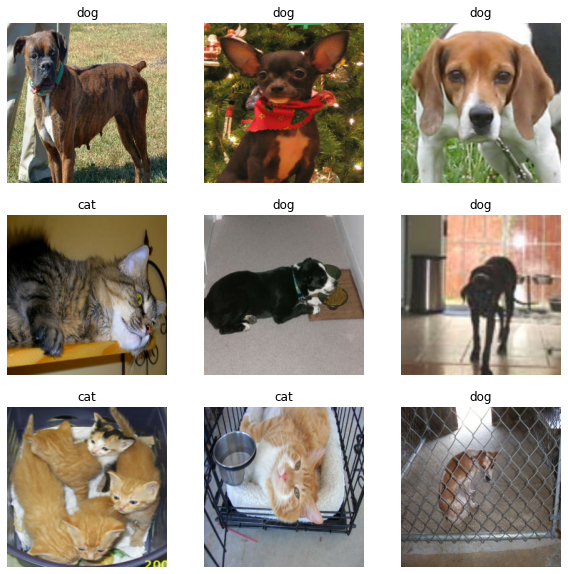

In [56]:
# Original Images with labels
show_imgs(test_ds)

In [57]:
# load model 
model = tf.keras.models.load_model("cat_vs_dog")
model_mobilenet = tf.keras.models.load_model("cat_vs_dog_mobilenet")

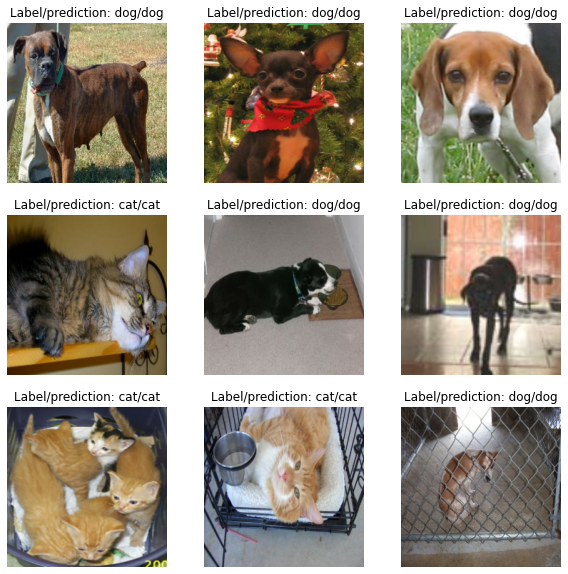

In [60]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.squeeze(tf.nn.sigmoid(predictions))
predictions = tf.where(predictions < 0.5, 0, 1)
# print("Predictions:\n", predictions.numpy())
# print("Labels:\n", label_batch)
class_names = ["cat", "dog"]
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f"Label/prediction: {class_names[label_batch[i]]}/{class_names[predictions[i]]}")
  plt.axis("off")

In [ ]:
# Testing with unseen data
!zip -r /content/cat_vs_dog.zip /content/cat_vs_dog/

In [ ]:
from google.colab import files
files.download("/content/cat_vs_dog.zip")

### Inference Script


In [ ]:
!unzip /content/content.zip

In [ ]:
# Load saved model
model = tf.keras.models.load_model("content/cat_vs_dog/")

In [68]:
def decode_img(img, png=True):
  """convert the compressed string into a 3d uint8 tensor"""
  if png:
    img = tf.image.decode_png(img, channels=3)
  else:
    img = tf.image.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [224, 224])

In [69]:
def process_path(file_path):
  """Read images into tensors"""
  ext = file_path.split(".")[-1]
  img = tf.io.read_file(file_path)
  if ext == "png":
    img = decode_img(img)
  else:
    img = decode_img(img, png=False)
  return img

In [71]:
def preprocess_img(img_path):
  """Preprocess images before feeding to our model 
  for prediction"""
  img = process_path(img_path)
  # img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
  img = tf.reshape(img, [1, 224, 224, 3])
  return tf.image.convert_image_dtype(img, dtype=tf.float32)


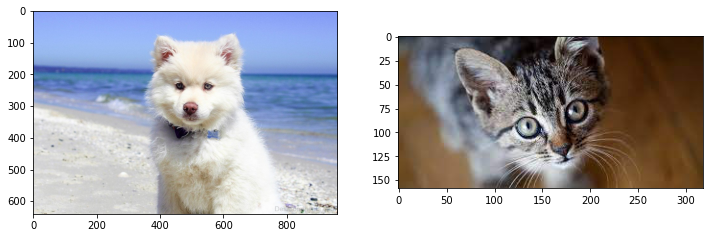

In [75]:
cat_img = "/content/cat.jfif"
dog_img = "/content/dog.jfif"
# img = preprocess_img
fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(dog_img))
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(cat_img))


Text(0.5, 1.0, 'Prediction: cat')

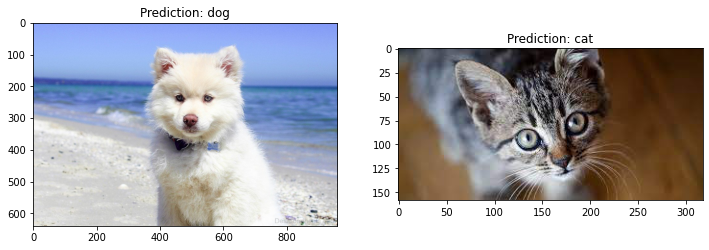

In [77]:
def make_prediction(img_path: str) -> str:
  """Making prediction"""
  img = preprocess_img(img_path)
  class_names = ["cat", "dog"]
  pred = model.predict(img).flatten()
  pred = tf.nn.sigmoid(pred)
  pred = tf.where(pred < 0.5, 0, 1)
  pred = class_names[pred.numpy()[0]]
  return pred
# make prediction with unseen images of a dog and a cat
dog_prediction = make_prediction(dog_img)
cat_prediction = make_prediction(cat_img)
fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(dog_img))
plt.title(f"Prediction: {dog_prediction}")
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(cat_img))
plt.title(f"Prediction: {cat_prediction}")
